# Filter ROMS output using dask

see:
 - https://docs.dask.org/en/latest/delayed.html
 - https://docs.dask.org/en/latest/delayed-best-practices.html

In [2]:
# Use a dask client
from dask.distributed import Client, LocalCluster, worker, progress, wait
import dask
from dask_jobqueue import SLURMCluster


In [3]:
cluster = SLURMCluster()
client=Client(cluster)
cluster.scale(8)
client


Bad key "backend.qt5" on line 5 in
/home/mrayson/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Client Scheduler: tcp://146.118.38.64:41154 Dashboard: http://146.118.38.64:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
import xarray as xr
import pandas as pd
import dask
import glob
from netCDF4 import Dataset
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
roms = xr.open_mfdataset('../ROMSdata/outputs/roms_nws_*his.nc', concat_dim='ocean_time')
roms

/home/mrayson/group/mrayson/miniconda3/envs/soda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/mrayson/group/mrayson/miniconda3/envs/soda/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to

<xarray.Dataset>
Dimensions:        (boundary: 4, eta_psi: 481, eta_rho: 482, eta_u: 482, eta_v: 481, ocean_time: 1197, s_rho: 30, s_w: 31, tracer: 2, xi_psi: 1009, xi_rho: 1010, xi_u: 1009, xi_v: 1010)
Coordinates:
    lat_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(481, 1009), meta=np.ndarray>
    lon_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
    lon_v          (eta_v, xi_v) float64 dask.array<chunksize=(481, 1010), meta=np.ndarray>
    lon_u          (eta_u, xi_u) float64 dask.array<chunksize=(482, 1009), meta=np.ndarray>
    lon_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(481, 1009), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
    lat_u          (eta_u, xi_u) float64 dask.array<chunksize=(482, 1009), meta=np.ndarray>
    lat_v          (eta_v, xi_v) float64 dask.array<chunksize=(481, 1010), meta=np.ndarray>
  * s_w            (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
  * s_rho          (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * ocean_time     (ocean_time) datetime64[ns] 2017-01-02 ... 2017-05-31T12:00:00
Dimensions without coordinates: boundary, eta_psi, eta_rho, eta_u, eta_v, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables:
    ntimes         (ocean_time) int32 107640 107640 107640 ... 107640 107640
    ndtfast        (ocean_time) int32 30 30 30 30 30 30 30 ... 30 30 30 30 30 30
    dt             (ocean_time) float64 120.0 120.0 120.0 ... 120.0 120.0 120.0
    dtfast         (ocean_time) float64 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
    dstart         (ocean_time) datetime64[ns] 2017-01-02 ... 2017-01-02
    nHIS           (ocean_time) int32 90 90 90 90 90 90 90 ... 90 90 90 90 90 90
    ndefHIS        (ocean_time) int32 720 720 720 720 720 ... 720 720 720 720
    nRST           (ocean_time) int32 720 720 720 720 720 ... 720 720 720 720
    ntsAVG         (ocean_time) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    nAVG           (ocean_time) int32 720 720 720 720 720 ... 720 720 720 720
    ndefAVG        (ocean_time) int32 720 720 720 720 720 ... 720 720 720 720
    nSTA           (ocean_time) int32 15 15 15 15 15 15 15 ... 15 15 15 15 15 15
    Falpha         (ocean_time) float64 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    Fbeta          (ocean_time) float64 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
    Fgamma         (ocean_time) float64 0.284 0.284 0.284 ... 0.284 0.284 0.284
    nl_tnu2        (ocean_time, tracer) float64 dask.array<chunksize=(9, 2), meta=np.ndarray>
    nl_visc2       (ocean_time) float64 15.0 15.0 15.0 15.0 ... 15.0 15.0 15.0
    LuvSponge      (ocean_time) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    LtracerSponge  (ocean_time, tracer) int32 dask.array<chunksize=(9, 2), meta=np.ndarray>
    Akt_bak        (ocean_time, tracer) float64 dask.array<chunksize=(9, 2), meta=np.ndarray>
    Akv_bak        (ocean_time) float64 1e-05 1e-05 1e-05 ... 1e-05 1e-05 1e-05
    Akk_bak        (ocean_time) float64 5e-06 5e-06 5e-06 ... 5e-06 5e-06 5e-06
    Akp_bak        (ocean_time) float64 5e-06 5e-06 5e-06 ... 5e-06 5e-06 5e-06
    rdrg           (ocean_time) float64 0.0003 0.0003 0.0003 ... 0.0003 0.0003
    rdrg2          (ocean_time) float64 0.003 0.003 0.003 ... 0.003 0.003 0.003
    Zob            (ocean_time) float64 0.02 0.02 0.02 0.02 ... 0.02 0.02 0.02
    Zos            (ocean_time) float64 0.02 0.02 0.02 0.02 ... 0.02 0.02 0.02
    Znudg          (ocean_time) float64 0.03333 0.03333 ... 0.03333 0.03333
    M2nudg         (ocean_time) float64 0.03333 0.03333 ... 0.03333 0.03333
    M3nudg         (ocean_time) float64 0.03333 0.03333 ... 0.03333 0.03333
    Tnudg          (ocean_time, tracer) float64 dask.array<chunksize=(9, 2), meta=np.ndarray>
    FSobc_in       (ocean_time, boundary) float64 dask.array<chunksize=(9, 4), meta=np.ndarray>
    FSobc_out      (ocean_time, boundary) float64 dask.array<chunksize

In [11]:
roms['zeta']

<xarray.DataArray 'zeta' (ocean_time: 1197, eta_rho: 482, xi_rho: 1010)>
dask.array<concatenate, shape=(1197, 482, 1010), dtype=float32, chunksize=(9, 482, 1010), chunktype=numpy.ndarray>
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(482, 1010), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2017-01-02 ... 2017-05-31T12:00:00
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  free-surface
    units:      meter
    time:       ocean_time
    grid:       grid
    location:   face
    field:      free-surface, scalar, series

In [7]:
def filt(ytmp, cutoff_dt, dt, btype='low', order=3, axis=0 ):
    """
    Butterworth filter the time series
    Inputs:
        cutoff_dt - cuttoff period [seconds]
        btype - 'low' or 'high' or 'band'
    """
    if not btype == 'band':
        Wn = dt/cutoff_dt
    else:
        Wn = [dt/co for co in cutoff_dt]
    (b, a) = signal.butter(order, Wn, btype=btype, analog=0, output='ba')
    
    return signal.filtfilt(b, a, ytmp, axis=axis)

In [8]:
dt = 10800
cutoff_dt = 30*3600

#zeta_filt = dask.delayed(filt)(roms['zeta'], cutoff_dt, dt)
#arr


In [ ]:
%%time
#from functools import partial
arr = roms['zeta']

# Compute the filted variable
arr_filt = xr.apply_ufunc(filt,
                          arr,cutoff_dt,dt,
                          dask='parallelized',
                          output_dtypes=[arr.dtype],
                          input_core_dims=[['ocean_time','eta_rho','xi_rho']]
                          kwargs={'axis': 0})

# Compute the residual
arr_pr = arr - arr_filt

# Variance
arr_var = (arr_pr**2).mean(axis=0)
arr_var.compute()

In [14]:
%%time

# Try a 3D array
arr = roms['temp'][:,20:30,:,:] # Do 5-layers (need more workers to do the whole thing)
#arr = roms['temp'] # Do 5-layers (need more workers to do the whole thing)


# Compute the filtered variable
arr_filt = xr.apply_ufunc(filt,
                          arr, cutoff_dt, dt,
                          dask='parallelized',
                          output_dtypes=[arr.dtype],
                          kwargs={'axis': 0})

# Compute the residual
arr_pr = arr - arr_filt

# Variance
arr_var = (arr_pr**2).mean(axis=0).compute()
arr_var.shape

KilledWorker: ("('filt-mean_chunk-938d1ea907d756f80b5689ae490fec1b', 30, 0, 0, 0)", <Worker 'tcp://146.118.38.111:33579', name: 1-0, memory: 0, processing: 2>)

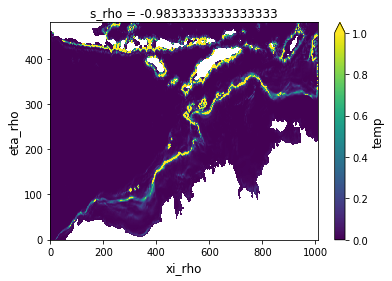

In [12]:
plt.figure()
arr_var[...].plot(vmin=0,vmax=1)